In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax.config import config as jax_config

jax_config.update("jax_enable_x64", True)

from tqdm import tqdm

import cryo_md

from cryo_md.data_generator import data_generator
from cryo_md.wpa_simulator.simulator import simulate_stack_traj
from cryo_md.md_engine import run_square_langevin
from cryo_md.optimizer import run_optimizer


In [3]:
np.random.seed(0)

# Generating Data

In [4]:
def generate_square(sides):
    square = jnp.array(
        [
            [-sides[1] / 2, -sides[1] / 2, sides[1] / 2, sides[1] / 2],
            [-sides[0] / 2, sides[0] / 2, sides[0] / 2, -sides[0] / 2],
            [0.0, 0.0, 0.0, 0.0],
        ]
    )

    return square


gen_models = jax.vmap(generate_square, in_axes=(0))

In [5]:
def get_colvar(square):
    length = jnp.linalg.norm(square[:, 0] - square[:, 3])
    height = jnp.linalg.norm(square[:, 0] - square[:, 1])

    return (height, length)


get_colvars = jax.vmap(get_colvar, in_axes=(0))

In [6]:
n_points = np.array([100, 70, 30])
centers = np.array([[64, 64], [64, 32], [32, 64]])
# centers = np.array([[64, 64], [32, 32]])
# centers = np.array([[64, 64]])
cov = np.array([[8, 0], [0, 8]])

data = jnp.array(data_generator(centers, cov, n_points))
models = gen_models(data)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# config = {
#     "box_size": 32,
#     "pixel_size": 4,
#     "sigma": 4.0,
#     "ctf_amp": 0.1,
#     "ctf_bfactor": 1.0,
#     "ctf_defocus": [0.5, 2.0],
#     "noise_snr": [0.5, 1.0],
#     "noise_radius_mask": 16,
# }

config = {
    "box_size": 32,
    "pixel_size": 4,
    "sigma": 4.0,
    "ctf_amp": 0.1,
    "ctf_bfactor": 1.0,
    "ctf_defocus": 0.0,
    "noise_snr": 10000.0,
    "noise_radius_mask": 16,
}

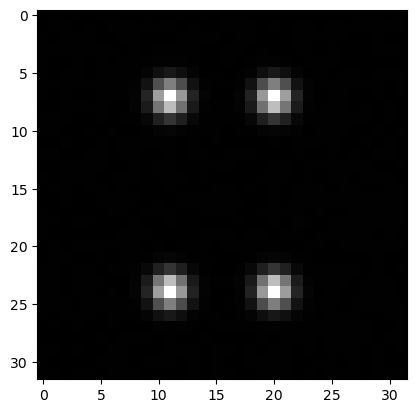

In [8]:
data_stack = simulate_stack_traj(models, config)
plt.imshow(data_stack.images[-1], cmap="gray")

# "MD" Simulator

In [9]:
ref_model = models[0:2][:2, :]
init_model = models[2:4][:2, :]

In [10]:
traj = run_square_langevin(
    init_model + 0.00001, init_model, n_steps=100, step_size=0.01
)

In [11]:
traj.shape, init_model.shape

((101, 2, 3, 4), (2, 3, 4))

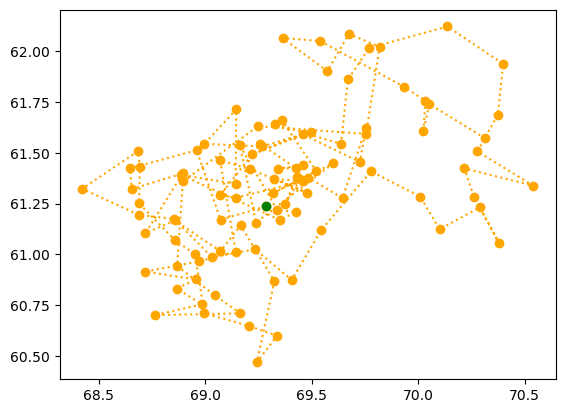

In [12]:
colvars_ref = get_colvar(init_model[0])
colvars_traj = get_colvars(traj[:, 0, :, :])

plt.plot(colvars_traj[0], colvars_traj[1], ls=":", marker="o", color="orange")
plt.plot(colvars_ref[0], colvars_ref[1], ls=":", marker="o", color="green")

# cryo_MD

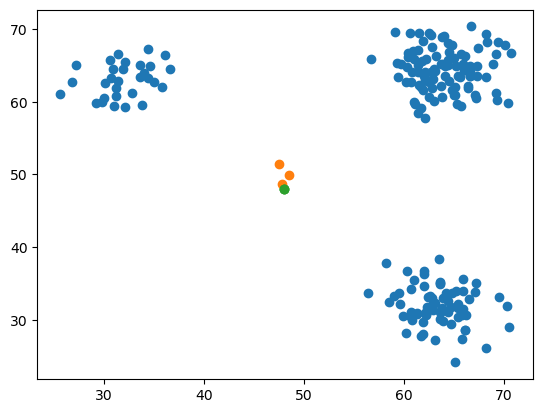

In [16]:
n_models = 4

ref_sides = np.array([[48.0, 48.0], [48.0, 48.0], [48.0, 48.0]])#, [48.0, 48.0]])
ref_models = gen_models(ref_sides)

init_sides = ref_sides.copy() + np.random.randn(*ref_sides.shape) * 3
init_models = gen_models(init_sides)

weights = np.ones(init_models.shape[0]) / init_models.shape[0]

weights = jnp.array(weights)

plt.scatter(data[:, 0], data[:, 1])
plt.scatter(init_sides[:, 0], init_sides[:, 1])
plt.scatter(ref_sides[:, 0], ref_sides[:, 1])

In [17]:
n_steps = 100
max_change = 1  # A
gamma = 0.8

batch_size = 30

traj, opt_weights, losses = run_optimizer(init_models, weights, data_stack, n_steps, max_change, gamma, batch_size, stride_neigh_list=1)

100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


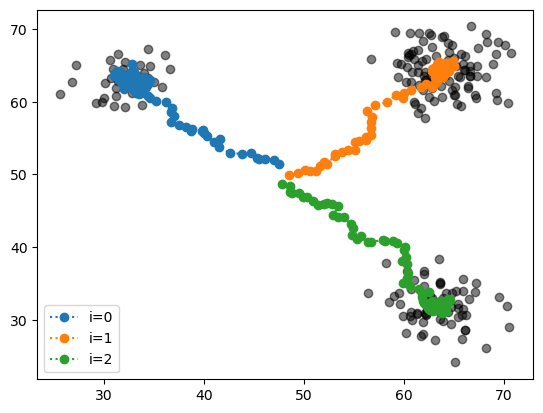

In [18]:
for i in range(traj.shape[1]):
    colvars = get_colvars(traj[:, i, :, :])
    plt.plot(colvars[0], colvars[1], ls=":", marker="o", label=f"i={i}")

plt.scatter(data[:, 0], data[:, 1], color="black", alpha=0.5)
plt.legend()

In [19]:
np.sort(opt_weights), np.sort(n_points / np.sum(n_points))

(array([0.21726466, 0.36990476, 0.41283058]), array([0.15, 0.35, 0.5 ]))